In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, Model

train = pd.read_csv("data/fmnist_train.csv")
test = pd.read_csv("data/fmnist_test.csv")

# Предобработка и первичный взгляд на данные

In [2]:
print(train.isnull().sum().max())
print(test.isnull().sum().max())

1
0


In [3]:
nan_columns = train.columns[train.isnull().any()].tolist()
print("Столбцы с пропусками:", nan_columns)

Столбцы с пропусками: ['pixel361', 'pixel362', 'pixel363', 'pixel364', 'pixel365', 'pixel366', 'pixel367', 'pixel368', 'pixel369', 'pixel370', 'pixel371', 'pixel372', 'pixel373', 'pixel374', 'pixel375', 'pixel376', 'pixel377', 'pixel378', 'pixel379', 'pixel380', 'pixel381', 'pixel382', 'pixel383', 'pixel384', 'pixel385', 'pixel386', 'pixel387', 'pixel388', 'pixel389', 'pixel390', 'pixel391', 'pixel392', 'pixel393', 'pixel394', 'pixel395', 'pixel396', 'pixel397', 'pixel398', 'pixel399', 'pixel400', 'pixel401', 'pixel402', 'pixel403', 'pixel404', 'pixel405', 'pixel406', 'pixel407', 'pixel408', 'pixel409', 'pixel410', 'pixel411', 'pixel412', 'pixel413', 'pixel414', 'pixel415', 'pixel416', 'pixel417', 'pixel418', 'pixel419', 'pixel420', 'pixel421', 'pixel422', 'pixel423', 'pixel424', 'pixel425', 'pixel426', 'pixel427', 'pixel428', 'pixel429', 'pixel430', 'pixel431', 'pixel432', 'pixel433', 'pixel434', 'pixel435', 'pixel436', 'pixel437', 'pixel438', 'pixel439', 'pixel440', 'pixel441', 'pixe

In [4]:
train.iloc[-1]

label           5.0
pixel1          0.0
pixel2          0.0
pixel3          0.0
pixel4          0.0
             ...   
pixel781        NaN
pixel782        NaN
pixel783        NaN
pixel784        NaN
Id          17039.0
Name: 17039, Length: 786, dtype: float64

Нашли 1 пустую строку, выбрасываем её

0
0


<Axes: xlabel='label', ylabel='count'>

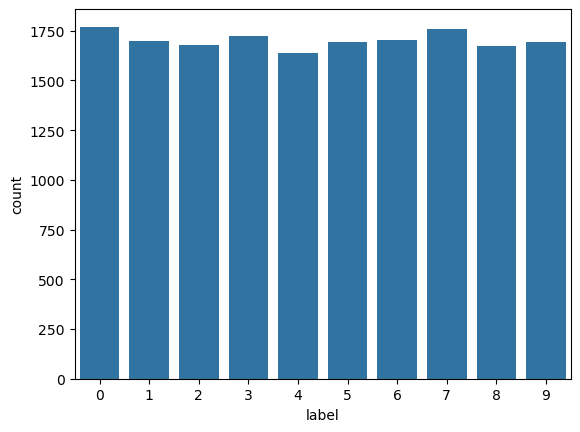

In [5]:
if train.isnull().sum().max() > 0:
    train = train.dropna()

if test.isnull().sum().max() > 0:
    test = test.dropna()


print(train.isnull().sum().max())
print(test.isnull().sum().max())

sns.countplot(x='label', data=train)

Дисбаланса не наблюдается

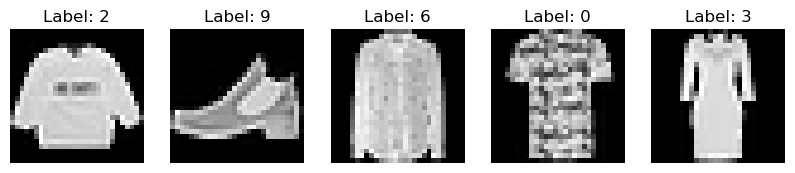

In [6]:
def plot_images(df, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        image = df.iloc[i, 1:-1].values.reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {df.iloc[i, 0]}")
        plt.axis('off')
    plt.show()

plot_images(train)

In [7]:
pixel_columns = [f"pixel{i}" for i in range(1, 784)]
test[pixel_columns]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,9,8,0,...,125,103,87,56,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,216,34,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,0,63,53,31,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,137,126,140,0,133,224,222,56,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,37,...,37,32,23,14,20,0,0,1,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,52,23,28,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,178,175,172,172,182,199,222,42,0,1
9998,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
print("Количество столбцов в train:", train.shape[1])
print("Количество столбцов в test:", test.shape[1])

Количество столбцов в train: 786
Количество столбцов в test: 785


In [9]:
pixel_columns = [f"pixel{i}" for i in range(1, 785)]

X_train = train[pixel_columns].values
y_train = train['label'].values
X_test = test[pixel_columns].values

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Форма X_train: (17039, 784)
Форма X_test: (10000, 784)


In [10]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=10)

In [11]:
y_train_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Простая модель

## Архитектура

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/envs/arima-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Обучение

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42
)

: 

In [ ]:
history = model.fit(X_train_split, y_train_split,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val_split, y_val_split))

Epoch 1/10


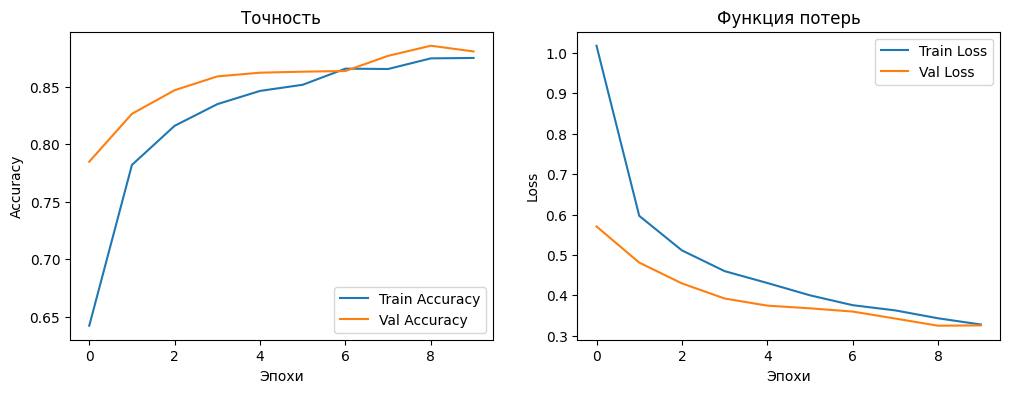

In [ ]:
import matplotlib.pyplot as plt

# График точности
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Предикт на тесте

In [ ]:
test_predictions = model.predict(X_test)
predicted_labels = np.argmax(test_predictions, axis=1)

submission = pd.DataFrame({
    'id': test['Id'],
    'label': predicted_labels
})
submission.to_csv('submission.csv', index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


# Метрики хорошие, но можно лучше

Будем использовать более продвинутую модель + аугментацию

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    Flatten(),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         524,5

 Total params: 668,266 (2.55 MB)

 Trainable params: 667,114 (2.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history = model.fit(datagen.flow(X_train_split, y_train_split, batch_size=128),
                    epochs=70,
                    validation_data=(X_val_split, y_val_split), callbacks=[early_stop, reduce_lr])

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.6305 - loss: 1.0592 - val_accuracy: 0.1362 - val_loss: 3.0013 - learning_rate: 0.0010
Epoch 2/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.7880 - loss: 0.5717 - val_accuracy: 0.2028 - val_loss: 2.8191 - learning_rate: 0.0010
Epoch 3/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.7962 - loss: 0.5386 - val_accuracy: 0.4261 - val_loss: 1.7750 - learning_rate: 0.0010
Epoch 4/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.8302 - loss: 0.4578 - val_accuracy: 0.7324 - val_loss: 0.7145 - learning_rate: 0.0010
Epoch 5/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.8382 - loss: 0.4448 - val_accuracy: 0.8377 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 6/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.8394 - loss: 0.4190 - val_accuracy: 0.8090 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 7/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.8465 - loss:

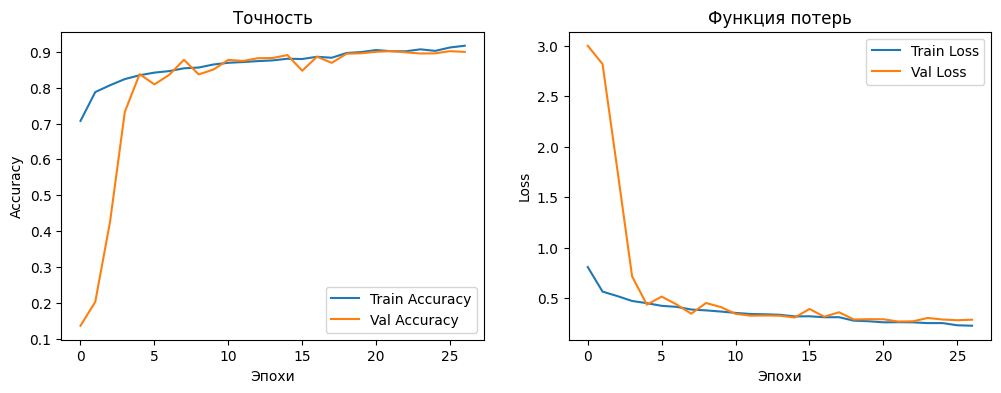

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_predictions = model.predict(X_test)
predicted_labels = np.argmax(test_predictions, axis=1)

submission = pd.DataFrame({
    'id': test['Id'],
    'label': predicted_labels
})
submission.to_csv('submission.csv', index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


# Пробуем RestNet

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    """Residual блок с двумя сверточными слоями."""
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(28, 28, 1))

x = layers.ZeroPadding2D((2, 2))(inputs)
x = layers.Conv2D(16, 3, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)

x = resnet_block(x, 32, stride=2)
x = resnet_block(x, 32)
x = resnet_block(x, 32)

x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_restnet = Model(inputs, outputs)
model_restnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 32, 32, 1)      │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 16)     │            160 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 32, 32, 16)     │             64 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 32, 32, 16)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 32, 32, 16)     │             64 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 32, 32, 16)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ activation_39[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 32, 32, 16)     │             64 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 32, 32, 16)     │              0 │ batch_normalization_4… │
│                           │                        │                │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 32, 32, 16)     │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ activation_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 32, 32, 16)     │             64 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41        

 Total params: 293,098 (1.12 MB)

 Trainable params: 291,530 (1.11 MB)

 Non-trainable params: 1,568 (6.12 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

model_restnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_restnet = model_restnet.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=128),
    epochs=50,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 27/107 ━━━━━━━━━━━━━━━━━━━━ 1:10 878ms/step - accuracy: 0.2388 - loss: 2.1947

NameError: name 'history_restnet' is not defined

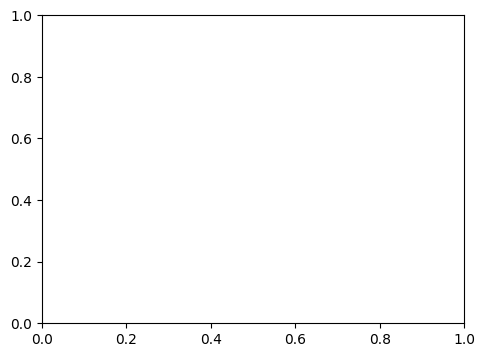

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_restnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_restnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_restnet.history['loss'], label='Train Loss')
plt.plot(history_restnet.history['val_loss'], label='Val Loss')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()

Оставляем Restnet

In [ ]:
test_predictions_restnet = model_restnet.predict(X_test)
predicted_labels_restnet = np.argmax(test_predictions_restnet, axis=1)

submission_restnet = pd.DataFrame({
    'id': test['Id'],
    'label': predicted_labels
})
submission_restnet.to_csv('submission.csv', index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step
